<a href="https://colab.research.google.com/github/gabrielbruschi/predicao_acoes/blob/main/Previsao_ARIMA_LSTM_PROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 27.7 MB/s 
     |████████████████████████████████| 9.8 MB 28.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
## For Arima
import pmdarima
import statsmodels.tsa.api as smt
## For Lstm
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as kprocessing
## For Prophet
from prophet import Prophet

import python_utils as ts

In [4]:
dtf = pd.read_csv('PTR4_bovespa_tratado.csv')
dtf = dtf.set_index(pd.DatetimeIndex(dtf['data_pregao'].values))
dtf.dropna(inplace=True)
dtf.head()

,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocio,data_pregao
2002-01-01,6.39,6.39,6.39,6.39,3.186628,0.0,2002-01-01
2002-01-02,6.45,6.49,6.39,6.41,3.192857,23920000.0,2002-01-02
2002-01-03,6.49,6.50,6.42,6.45,3.214662,39043200.0,2002-01-03
2002-01-04,6.38,6.45,6.32,6.41,3.194726,21500800.0,2002-01-04
2002-01-07,6.38,6.60,6.38,6.55,3.264501,40406400.0,2002-01-07


#Particionar os dados
O primeiro passo é dividir os dados entre treino e teste

In [11]:
'''
Split train/test from any given data point.
:parameter
    :param ts: pandas Series
    :param test: num or str - test size (ex. 0.20) or index position
                 (ex. "yyyy-mm-dd", 1000)
:return
    ts_train, ts_test
'''
def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ 
                      ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, 
                               sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Treino", 
                      color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Teste", 
                     color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    return ts_train, ts_test

--- splitting at index:  4061 | 2018-04-04 00:00:00 | test size: 0.2  ---


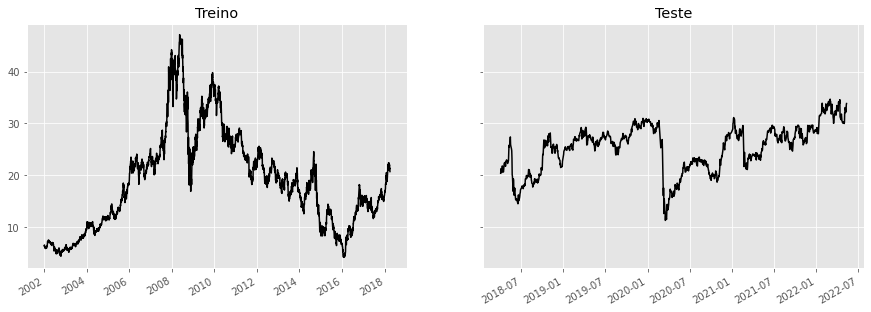

In [12]:
ts_train, ts_test = split_train_test(dtf['preco_fechamento'])

#RANDOM WALK 

In [13]:
###############################################################################
#                           RANDOM WALK                                       #
###############################################################################
'''
Generate a Random Walk process.
:parameter
    :param y0: num - starting value
    :param n: num - length of process
    :param ymin: num - limit
    :param ymax: num - limit
'''
def utils_generate_rw(y0, n, sigma, ymin=None, ymax=None):
    rw = [y0]
    for t in range(1, n):
        yt = rw[t-1] + np.random.normal(0,sigma)
        if (ymax is not None) and (yt > ymax):
            yt = rw[t-1] - abs(np.random.normal(0,sigma))
        elif (ymin is not None) and (yt < ymin):
            yt = rw[t-1] + abs(np.random.normal(0,sigma))
        rw.append(yt)
    return rw

In [14]:
'''
Simulate Random Walk from params of a given ts: 
    y[t+1] = y[t] + wn~(0,σ)
'''
def simulate_rw(ts_train, ts_test, figsize=(15,10)):
    ## simulate train
    diff_ts = ts_train - ts_train.shift(1)
    rw = utils_generate_rw(y0=ts_train[0], n=len(ts_train),
         sigma=diff_ts.std(), ymin=ts_train.min(), 
         ymax=ts_train.max())
    dtf_train = ts_train.to_frame(name="ts").merge(
                 pd.DataFrame(rw, index=ts_train.index, 
                              columns=["model"]), 
                              how='left', left_index=True,
                              right_index=True)
    ## test
    rw = utils_generate_rw(y0=ts_train[-1], n=len(ts_test), 
                           sigma=diff_ts.std(), ymin=ts_train.min(), 
                           ymax=ts_train.max())
    dtf_test = ts_test.to_frame(name="ts").merge(
                 pd.DataFrame(rw, index=ts_test.index, 
                              columns=["forecast"]), how='left', 
                              left_index=True, right_index=True)
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, 
                                  title="Random Walk Simulation")
    return dtf
'''
Evaluation metrics for predictions.
:parameter
    :param dtf: DataFrame with columns raw values, fitted training  
                 values, predicted test values
:return
    dataframe with raw ts and forecast
'''
def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

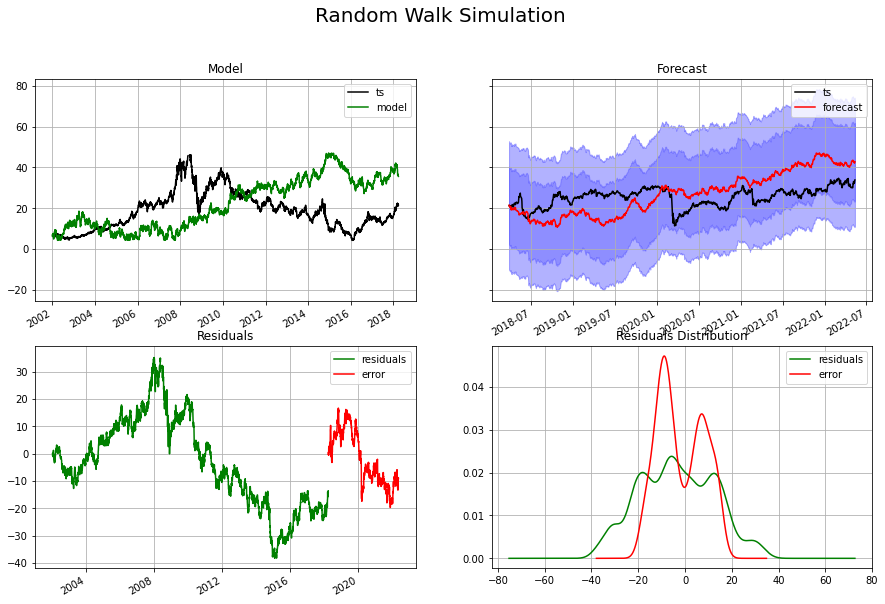

Training --> Residuals mean: -4.0  | std: 16.0
Test --> Error mean: -2.0  | std: 10.0  | mae: 9.0  | mape: 36.0 %  | mse: 97.0  | rmse: 10.0


In [15]:
preds = simulate_rw(ts_train, ts_test)

**mae** (mean absolute error):
Significa que a previsão pode variar 9 pontos para cima ou para baixo.
Ex: random walk previu 30 reais o preço de fechamento da ação, porem devemos atentar que a taxa de erro pode ser de 9 reais.**negrito**\

#Utils


In [10]:
'''
Evaluation metrics for predictions.
:parameter
    :param dtf: DataFrame with columns raw values, fitted training  
                 values, predicted test values
:return
    dataframe with raw ts and forecast
'''
def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

#Arima
The hard part of modeling Arima is to find the right parameters combination. Luckily there is a package that does that job for us: pmdarima

##Arima tunner

In [14]:
#Melhores parametros do ARIMA; order e seasonal_order
best_model = pmdarima.auto_arima(dtf['preco_fechamento'], # exogenous=exog                                   
                                 seasonal=True, stationary=False, 
                                 m=7, information_criterion='aic', 
                                 max_order=20,                                     
                                 max_p=10, max_d=3, max_q=10,                                     
                                 max_P=10, max_D=3, max_Q=10,                                   
                                 error_action='ignore')
print("best model --> (p, d, q):", best_model.order, " and  (P, D, Q, s):", best_model.seasonal_order)

best model --> (p, d, q): (2, 1, 3)  and  (P, D, Q, s): (0, 0, 0, 7)


##Arima algoritmo

In [22]:
'''
Fit SARIMAX (Seasonal ARIMA with External Regressors):  
    y[t+1] = (c + a0*y[t] + a1*y[t-1] +...+ ap*y[t-p]) + (e[t] + 
              b1*e[t-1] + b2*e[t-2] +...+ bq*e[t-q]) + (B*X[t])
:parameter
    :param ts_train: pandas timeseries
    :param ts_test: pandas timeseries
    :param order: tuple - ARIMA(p,d,q) --> p: lag order (AR), d: 
                  degree of differencing (to remove trend), q: order 
                  of moving average (MA)
    :param seasonal_order: tuple - (P,D,Q,s) --> s: number of 
                  observations per seasonal (ex. 7 for weekly 
                  seasonality with daily data, 12 for yearly 
                  seasonality with monthly data)
    :param exog_train: pandas dataframe or numpy array
    :param exog_test: pandas dataframe or numpy array
:return
    dtf with predictons and the model
'''
def fit_sarimax(ts_train, ts_test, order=(1,0,1), 
                seasonal_order=(0,0,0,0), exog_train=None, 
                exog_test=None, figsize=(15,10)):
    ## train
    model = smt.SARIMAX(ts_train, order=order, 
                        seasonal_order=seasonal_order, 
                        exog=exog_train, enforce_stationarity=False, 
                        enforce_invertibility=False).fit()
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = model.fittedvalues
    
    ## test
    dtf_test = ts_test.to_frame(name="ts")
    dtf_test["forecast"] = model.predict(start=len(ts_train), 
                            end=len(ts_train)+len(ts_test)-1, 
                            exog=exog_test)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    title = "ARIMA "+str(order) if exog_train is None else "ARIMAX "+str(order)
    title = "S"+title+" x "+str(seasonal_order) if  np.sum(seasonal_order) > 0 else title
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, title=title)
    return dtf, model

In [ ]:
dtf, model = fit_sarimax(ts_train, ts_test, order=(2,1,3), 
                         seasonal_order=(0,0,0,7))

#LSTM

I will use a really simple neural network: a lstm layer + a fully connected output layer with an input of dimension 365, meaning that it will have a whole year as memory (losing 365 days of training).

In [20]:
## Keras models
model = models.Sequential()
model.add( layers.LSTM(input_shape=(1,365), units=50, 
           activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')

In [19]:
'''
Preprocess a ts partitioning into X and y.
:parameter
    :param ts: pandas timeseries
    :param s: num - number of observations per seasonal (ex. 7 for weekly seasonality with daily data, 12 for yearly seasonality with monthly data)
    :param scaler: sklearn scaler object - if None is fitted
    :param exog: pandas dataframe or numpy array
:return
    X, y, scaler
'''
def utils_preprocess_ts(ts, s, scaler=None, exog=None):
    ## scale
    if scaler is None:
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    ts_preprocessed = scaler.fit_transform(ts.values.reshape(-1,1)).reshape(-1)        
    
    ## create X,y for train
    ts_preprocessed = kprocessing.sequence.TimeseriesGenerator(data=ts_preprocessed, 
                                                               targets=ts_preprocessed, 
                                                               length=s, batch_size=1)
    lst_X, lst_y = [], []
    for i in range(len(ts_preprocessed)):
        xi, yi = ts_preprocessed[i]
        lst_X.append(xi)
        lst_y.append(yi)
    X = np.array(lst_X)
    y = np.array(lst_y)
    return X, y, scaler
'''
Get fitted values.
'''
def utils_fitted_lstm(ts, model, scaler, exog=None):
    ## scale
    ts_preprocessed = scaler.fit_transform(ts.values.reshape(-1,1)).reshape(-1) 
    
    ## create Xy, predict = fitted
    s = model.input_shape[-1]
    lst_fitted = [np.nan]*s
    for i in range(len(ts_preprocessed)):
        end_ix = i + s
        if end_ix > len(ts_preprocessed)-1:
            break
        X = ts_preprocessed[i:end_ix]
        X = np.array(X)
        X = np.reshape(X, (1,1,X.shape[0]))
        fit = model.predict(X)
        fit = scaler.inverse_transform(fit)[0][0]
        lst_fitted.append(fit)
    return np.array(lst_fitted)
'''
Predict ts using previous predictions.
'''
def utils_predict_lstm(ts, model, scaler, pred_ahead, exog=None):
    ## scale
    s = model.input_shape[-1]
    ts_preprocessed = list(scaler.fit_transform(ts[-s:].values.reshape(-1,1))) 
    
    ## predict, append, re-predict
    lst_preds = []
    for i in range(pred_ahead):
        X = np.array(ts_preprocessed[len(ts_preprocessed)-s:])
        X = np.reshape(X, (1,1,X.shape[0]))
        pred = model.predict(X)
        ts_preprocessed.append(pred)
        pred = scaler.inverse_transform(pred)[0][0]
        lst_preds.append(pred)
    return np.array(lst_preds)

In [18]:
'''
Fit Long short-term memory neural network.
:parameter
    :param ts: pandas timeseries
    :param exog: pandas dataframe or numpy array
    :param s: num - number of observations per seasonal (ex. 7 for weekly seasonality with daily data, 12 for yearly seasonality with monthly data)
:return
    generator, scaler 
'''
def fit_lstm(ts_train, ts_test, model, exog=None, s=20, 
             figsize=(15,5)):
    ## check
    print("Seasonality: using the last", s, "observations to predict the next 1")
    
    ## preprocess train
    X_train, y_train, scaler = utils_preprocess_ts(ts_train, 
                                       scaler=None, exog=exog, s=s)
    
    ## lstm
    if model is None:
        model = models.Sequential()
        model.add( layers.LSTM(input_shape=X_train.shape[1:], units=50, activation='relu', return_sequences=False) )
        model.add( layers.Dense(1) )
        model.compile(optimizer='adam', loss='mean_absolute_error')
    
    ## train
    print(model.summary())
    training = model.fit(x=X_train, y=y_train, batch_size=1, 
                         epochs=100, shuffle=True, verbose=0, 
                         validation_split=0.3)
    
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = utils_fitted_lstm(ts_train, training.model, 
                                           scaler, exog)
    dtf_train["model"] = dtf_train["model"].fillna(method='bfill')
    
    ## test
    preds = utils_predict_lstm(ts_train[-s:], training.model, 
                               scaler, pred_ahead=len(ts_test), 
                               exog=None)
    dtf_test = ts_test.to_frame(name="ts").merge(
                       pd.DataFrame(data=preds, index=ts_test.index, 
                                    columns=["forecast"]),
               how='left', left_index=True, right_index=True)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, 
                                  title="LSTM (memory:"+str(s)+")")
    return dtf, training.model

In [ ]:
dtf, model = fit_lstm(ts_train, ts_test, model, s=365)

#Prophet
The Facebook Prophet model is composed of 3 componentes:

y = trend + seasonality + holidays

Don’t forget: the package takes a data frame as input (not a pandas Series) with 2 columns (ds with dates and y with values)

##Prophet ajuste dataset

In [16]:
dtf_train = ts_train.reset_index().rename(columns={"index":"ds", 
                                                   "preco_fechamento":"y"})
dtf_test = ts_test.reset_index().rename(columns={"index":"ds", 
                                                 "preco_fechamento":"y"})
dtf_train.tail()

,ds,y
4056,2018-03-27,21.44
4057,2018-03-28,21.20
4058,2018-03-29,21.41
4059,2018-04-02,20.90
4060,2018-04-03,20.71


In [38]:
dtf_train

,ds,y
0,2002-01-01,6.39
1,2002-01-02,6.41
2,2002-01-03,6.45
3,2002-01-04,6.41
4,2002-01-07,6.55
...,...,...
4056,2018-03-27,21.44
4057,2018-03-28,21.20
4058,2018-03-29,21.41
4059,2018-04-02,20.90


In [39]:
dtf_test

,ds,y
0,2018-04-04,20.38
1,2018-04-05,21.15
2,2018-04-06,21.28
3,2018-04-09,20.53
4,2018-04-10,21.40
...,...,...
1011,2022-05-06,33.06
1012,2022-05-09,32.16
1013,2022-05-10,32.44
1014,2022-05-11,33.57


##Prophet tunning

In [17]:
model = Prophet(growth="linear", changepoints=None, 
                n_changepoints=25,
                seasonality_mode="multiplicative",
                yearly_seasonality="auto", 
                weekly_seasonality="auto", 
                daily_seasonality=False,
                holidays=None)

##Prophet algoritmo

In [41]:
'''
Fits prophet on Business Data:
    y = trend + seasonality + holidays
:parameter
    :param dtf_train: pandas Dataframe with columns 'ds' (dates), 
             'y' (values), 'cap' (capacity if growth="logistic"), 
             other additional regressor
    :param dtf_test: pandas Dataframe with columns 'ds' (dates), 'y' 
                     (values), 'cap' (capacity if 
                      growth="logistic"), 
                      other additional regressor
    :param lst_exog: list - names of variables
    :param freq: str - "D" daily, "M" monthly, "Y" annual, "MS" 
                       monthly start ...
:return
    dtf with predictons and the model
'''
def fit_prophet(dtf_train, dtf_test, lst_exog=None, model=None, 
                freq="D", figsize=(15,10)):
    ## train
    model.fit(dtf_train)
    
    ## test
    dtf_prophet = model.make_future_dataframe(periods=len(dtf_test), 
                  freq=freq, include_history=True)
    dtf_prophet = model.predict(dtf_prophet)
    dtf_train = dtf_train.merge(dtf_prophet[["ds","yhat"]], 
                how="left").rename(columns={'yhat':'model', 
                'y':'ts'}).set_index("ds")
    dtf_test = dtf_test.merge(dtf_prophet[["ds","yhat"]], 
                how="left").rename(columns={'yhat':'forecast',  
                'y':'ts'}).set_index("ds")
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, 
                                  title="Prophet")
    return dtf, model

In [ ]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D")